# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

## Imports

In [ ]:
! git clone https://github.com/GalaxUniv/tinyai.git
! pip install tinyai/.
! pip uninstall torchaudio -y

Cloning into 'tinyai'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 276 (delta 11), reused 21 (delta 5), pack-reused 246
Receiving objects: 100% (276/276), 58.19 MiB | 26.77 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Processing ./tinyai
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *
from tinyai.fid import ImageEval

In [ ]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def noisify(x0):
    device = x0.device
    al_t = torch.rand((len(x0), 1, 1, 1), device=device)
    ε = torch.randn(x0.shape, device=device)
    xt = al_t.sqrt()*x0 + (1-al_t).sqrt()*ε
    return xt,al_t.squeeze().logit()

Note the `.logit()` we are tring to predict the `t` (the noise) which is in range of (0,1) if we don't `squeeze().logit()` it would go thought a sigmoid and the value changing from 0.99 to 0.999 changes a lot in this example.

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dl = dls.train
xt,amt = next(iter(dl))

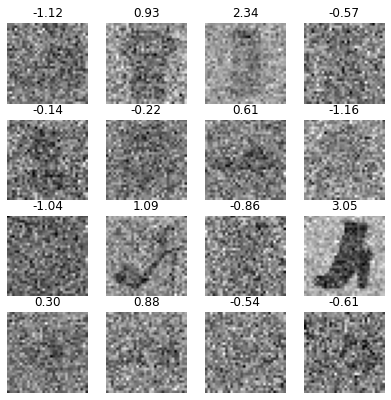

In [ ]:
titles = [f'{o:.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

In [ ]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return torch.full((len(x),), 0.5)

In [ ]:
metrics = MetricsCB()

This is ourbaseline where we predict 0.5 all the time.

In [ ]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '3.567', 'epoch': 0, 'train': 'eval'}


Another way to do this

In [ ]:
F.mse_loss(amt,torch.full(amt.shape, 0.5))

tensor(3.7227)

In [ ]:
def flat_mse(x,y): return F.mse_loss(x.flatten(), y.flatten())

In [ ]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout(0.2), nn.Linear(nfs[-1], 1, bias=False)]
    return nn.Sequential(*layers)

In [ ]:
opt_func = partial(optim.Adam, eps=1e-5)
epochs = 20
lr = 1e-2

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.320,0,train
0.230,0,eval
0.165,1,train
0.205,1,eval
0.159,2,train
0.153,2,eval
0.172,3,train
0.171,3,eval
0.161,4,train
0.537,4,eval


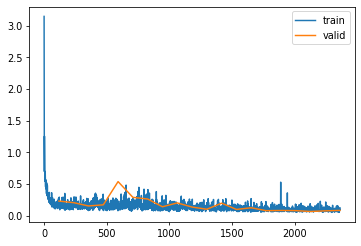

In [ ]:
learn.fit(epochs)

In [ ]:
#torch.save(learn.model, 'models/noisepred_sig.pkl')
# tmodel = learn.model
tmodel = torch.load('models/noisepred_sig.pkl').cuda()

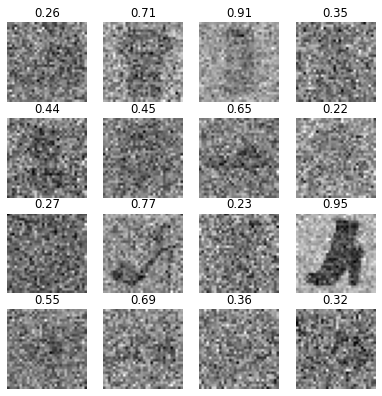

In [ ]:
with torch.no_grad(): a = to_cpu(tmodel(xt.cuda()).squeeze())
titles = [f'{o.sigmoid():.2f}' for o in a[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

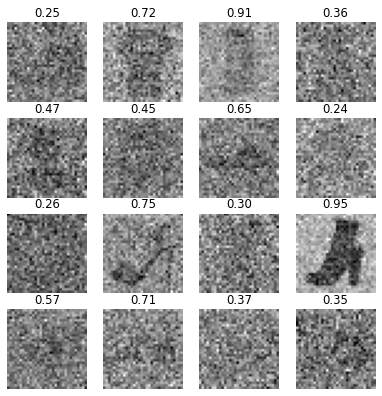

In [ ]:
titles = [f'{o.sigmoid():.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

## No-time model

In [ ]:
from diffusers import UNet2DModel
from torch.utils.data import DataLoader,default_collate

In [ ]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [ ]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand((n,)).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape).to(x0)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return xt, ε

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(x,0).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
lr = 4e-3
epochs = 25
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.401,0,train
0.075,0,eval
0.061,1,train
0.056,1,eval
0.050,2,train
0.048,2,eval
0.046,3,train
0.050,3,eval
0.045,4,train
0.045,4,eval


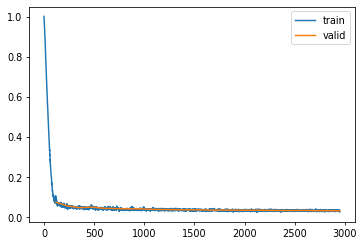

In [ ]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model, 'models/fashion_no-t.pkl')
model = learn.model = torch.load('models/fashion_no-t.pkl').cuda()

## Sampling

In [ ]:
sz = (2048,1,32,32)

In [ ]:
sz = (512,1,32,32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cmodel = torch.load('drive/MyDrive/models/tinyai/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    med = a.median()
    a = a.clamp(med/2,med*2)
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [ ]:
# def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
#     sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
#     x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-0.5,0.5)
#     if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
#     x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
#     x_t += sig * torch.randn(x_t.shape).to(x_t)
#     return x_0_hat

In [ ]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).to(next(model.parameters()).device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model(x_t)
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [ ]:
set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)

In [ ]:
# model-t eta 1.0
ie.fid(s),ie.kid(s),s.shape

(7.564208984375, -0.017351670190691948, torch.Size([512, 1, 32, 32]))

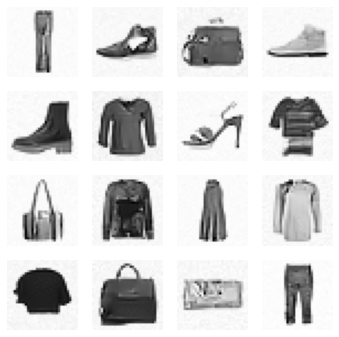

In [ ]:
show_images(s[:16], imsize=1.5)

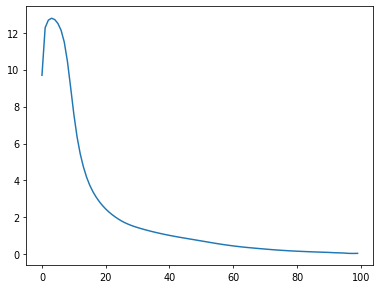

In [ ]:
plt.plot([ie.kid((o*2).clamp(-1,1)) for o in preds]);